# Capstone III - Daegu Apartment
## Domain Knowledge
### Context
Apartments are one of the answers to the housing needs of modern society due to limited 
residential land and dense business activities in urban areas. Therefore, it will be very interesting 
to examine apartment prices influenced by various internal and external factors.  
 
Individuals or companies usually make apartment (unit) offers. Bidders can sell units on a platform 
by determining their apartments’ prices. That way is quite difficult for apartment owners to adjust 
to market prices. If the price is too high compared to the market price, it will certainly be difficult 
to make sales. Conversely, if it is too low, the owner will find it difficult to get maximum profit.

### Business Problem
1. **Price Prediction**: Predicting the sale price of apartments based on various features.
2. **Feature Importance**: Identifying which features most significantly influence apartment prices.

### Goals
1. **Accurate Price Prediction**: Develop a model to accurately predict apartment prices ranges to help owners set competitive prices.
2. **Understand Key Factors**: Identify the key factors that influence apartment prices to inform marketing and development strategies.

### Business Questioin
1. **What is the predicted sale price of an apartment given its features?**
2. **Which features are the most important in determining apartment prices?**


### Data Features and Description
Features 
-  Hallway Type: Apartment type 
-  TimeToSubway: Time needed to the nearest subway station 
-  SubwayStation: The name of the nearest subway station 
-  N_FacilitiesNearBy(ETC): The number of facilities nearby 
-  N_FacilitiesNearBy(PublicOffice): The number of public office facilities nearby 
-  N_SchoolNearBy(University): The number of universities nearby 
-  N_Parkinglot(Basement): The number of the parking lot 
-  YearBuilt: The year the apartment was built 
-  N_FacilitiesInApt: Number of facilities in the apartment 
-  Size(sqft): The apartment size (in square feet) 
-  SalePrice: The apartment price (Won)

## Maching Learning

### Data

In [172]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform

import pickle

In [2]:
df = pd.read_csv("./data/data_daegu_apartment.csv")

In [3]:
df.head()

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1387,346017
1,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,5.0,1.0,0.0,1986,4,914,150442
2,mixed,15min~20min,Chil-sung-market,1.0,7.0,3.0,56.0,1997,5,558,61946
3,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,914,165486
4,terraced,0-5min,Sin-nam,0.0,1.0,2.0,536.0,2006,5,1743,311504


In [4]:
df.shape[0]

4123

### Data Limitation

In [101]:
df.describe().T[['min', 'max']]

,min,max
N_FacilitiesNearBy(ETC),0.0,5.0
N_FacilitiesNearBy(PublicOffice),0.0,7.0
N_SchoolNearBy(University),0.0,5.0
N_Parkinglot(Basement),0.0,1321.0
YearBuilt,1978.0,2015.0
N_FacilitiesInApt,1.0,10.0
Size(sqf),135.0,2337.0
SalePrice,32743.0,585840.0


### Data Preparation

#### Check missing value

In [5]:
dataDesc = []
for i in df.columns:
    dataDesc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((df[i].isna().sum() / len(df)) * 100, 2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values])
    
pd.DataFrame(dataDesc, columns=[
    "Data Features",
    "Data Types",
    "Null Val",
    "Null Percentage",
    "Unique",
    "Unique Sample"])

,Data Features,Data Types,Null Val,Null Percentage,Unique,Unique Sample
0,HallwayType,object,0,0.0,3,"[terraced, mixed]"
1,TimeToSubway,object,0,0.0,5,"[10min~15min, no_bus_stop_nearby]"
2,SubwayStation,object,0,0.0,8,"[Sin-nam, Myung-duk]"
3,N_FacilitiesNearBy(ETC),float64,0,0.0,4,"[5.0, 0.0]"
4,N_FacilitiesNearBy(PublicOffice),float64,0,0.0,8,"[0.0, 4.0]"
5,N_SchoolNearBy(University),float64,0,0.0,6,"[3.0, 1.0]"
6,N_Parkinglot(Basement),float64,0,0.0,20,"[203.0, 798.0]"
7,YearBuilt,int64,0,0.0,16,"[1997, 2015]"
8,N_FacilitiesInApt,int64,0,0.0,9,"[3, 1]"
9,Size(sqf),int64,0,0.0,89,"[871, 832]"


column pada data tidak terlihat saling terkait.

<Axes: >

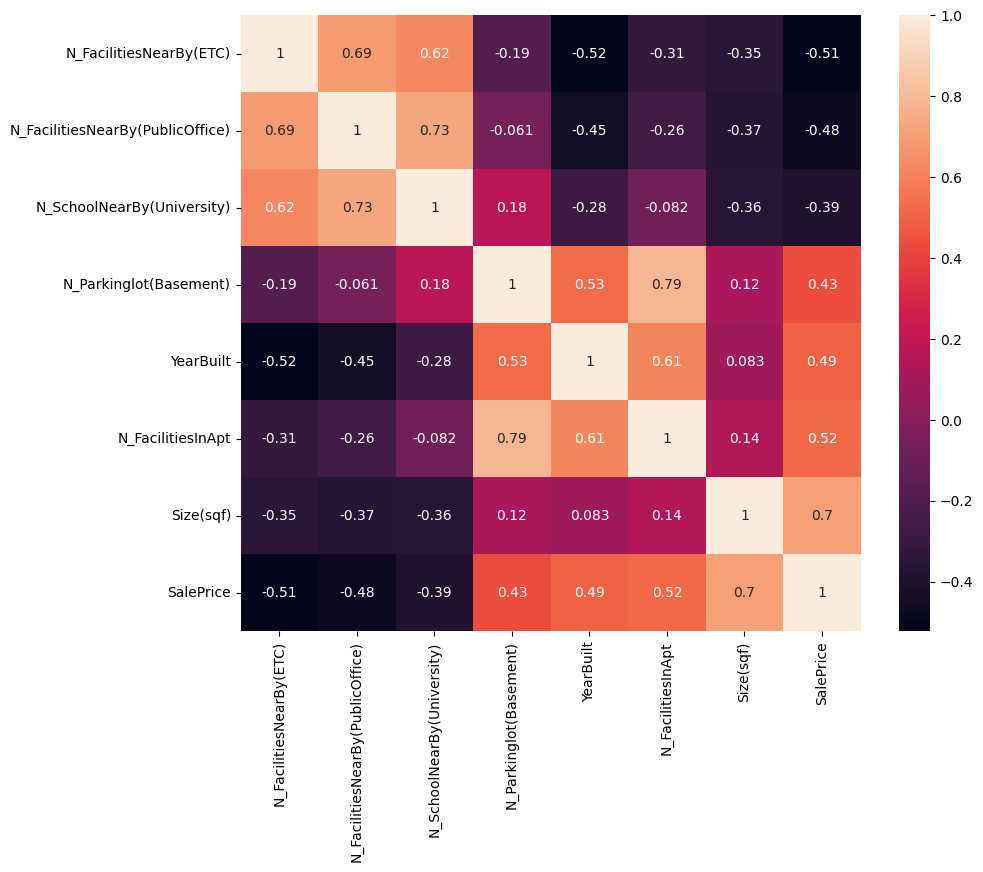

In [6]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(method='spearman', numeric_only=True), annot=True)

#### Feature and Target

karena yang akan diprediksi adalah price maka dependent / target variable yang digunakan adalah price. 
column lainnya tidak terlihat saling terkait. maka column lainnya digunakan sebagai independent / feature variable untuk memprediksi price dan juga melihat feature mana yang paling significant

In [7]:
X = df.drop(columns='SalePrice')
y = df['SalePrice']

#### Data Splitting

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)

#### Preprocessor (Encoding and Scalling)

In [9]:
X['HallwayType'].unique()

array(['terraced', 'mixed', 'corridor'], dtype=object)

In [10]:
X['TimeToSubway'].unique()
categories = [['0-5min', '5min~10min', '10min~15min', '15min~20min','no_bus_stop_nearby']]
categories

[['0-5min', '5min~10min', '10min~15min', '15min~20min', 'no_bus_stop_nearby']]

In [11]:
X['SubwayStation'].unique()

array(['Kyungbuk_uni_hospital', 'Chil-sung-market', 'Bangoge', 'Sin-nam',
       'Banwoldang', 'no_subway_nearby', 'Myung-duk', 'Daegu'],
      dtype=object)

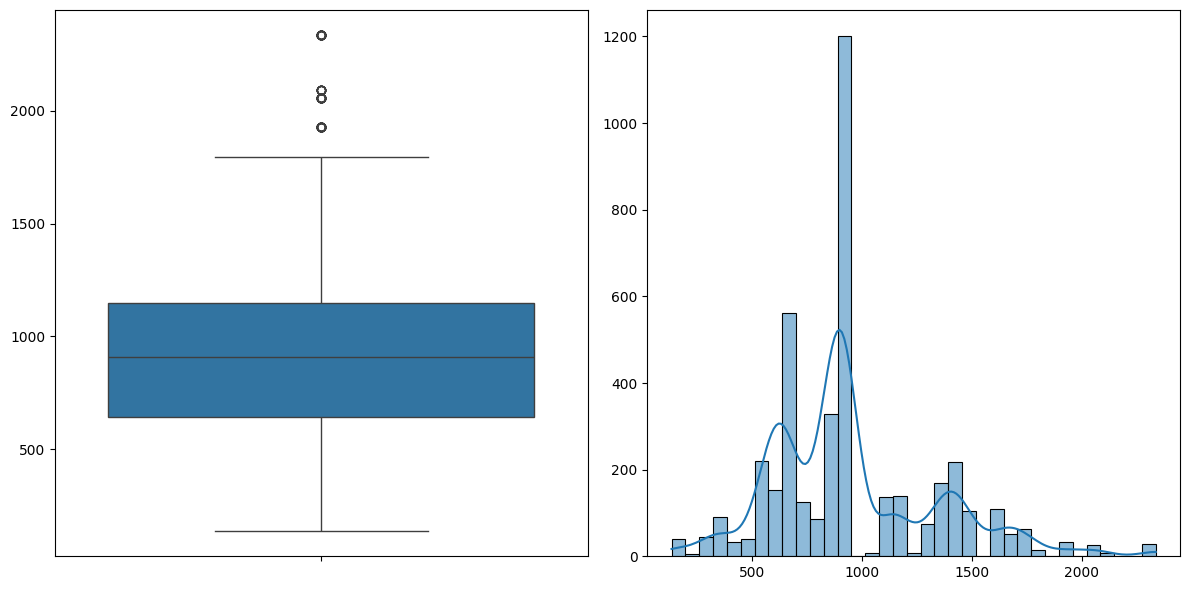

In [12]:
fig, (ax_box, ax_hist) = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(df['Size(sqf)'], ax=ax_box)
ax_box.set(title='', xlabel='', ylabel='')
sns.histplot(df['Size(sqf)'], ax=ax_hist, kde=True)
ax_hist.set(title='', xlabel='', ylabel='')
plt.tight_layout()
plt.show()

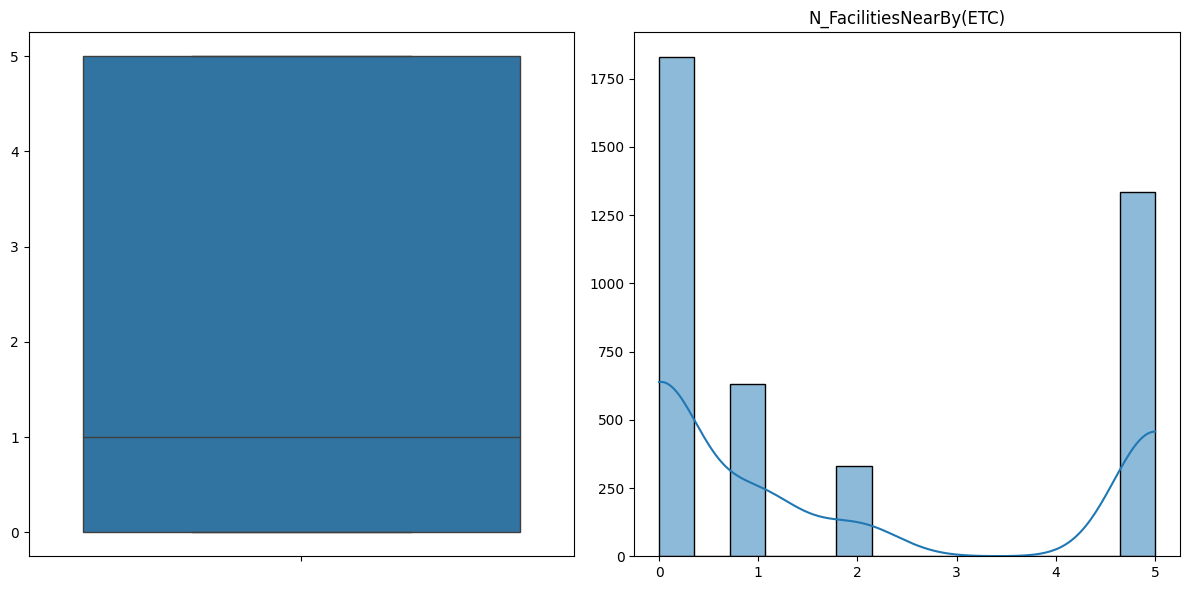

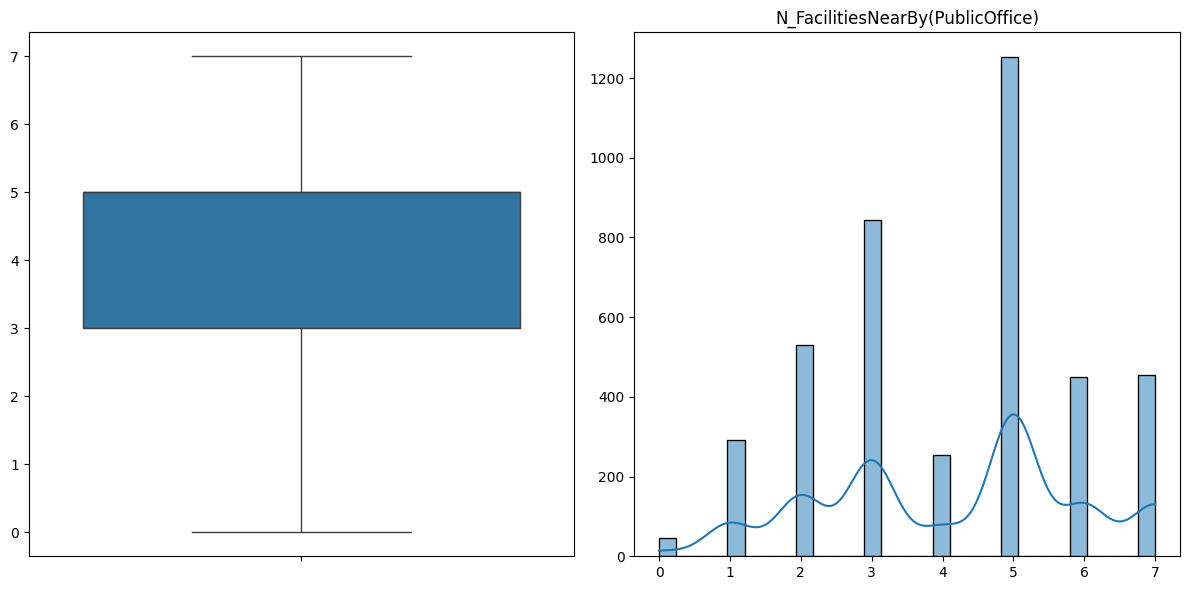

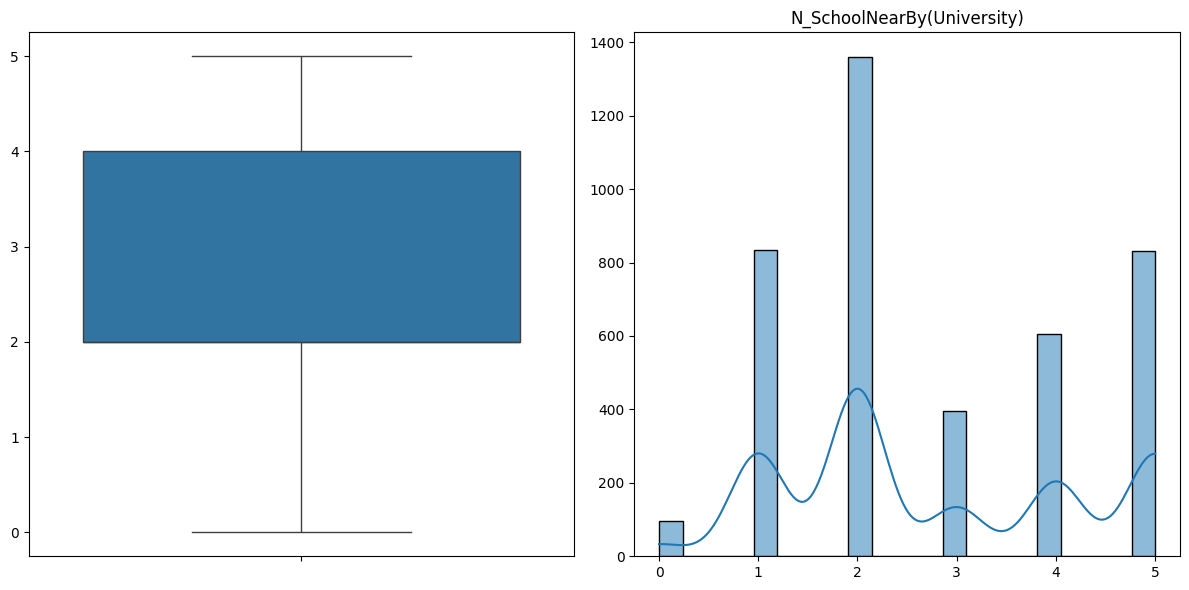

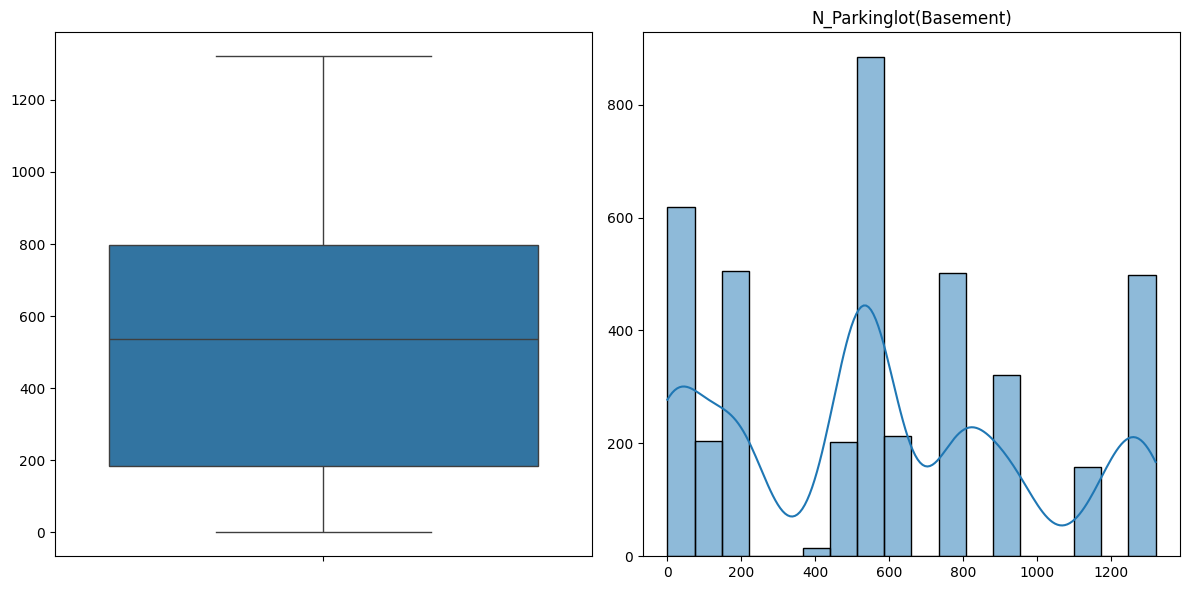

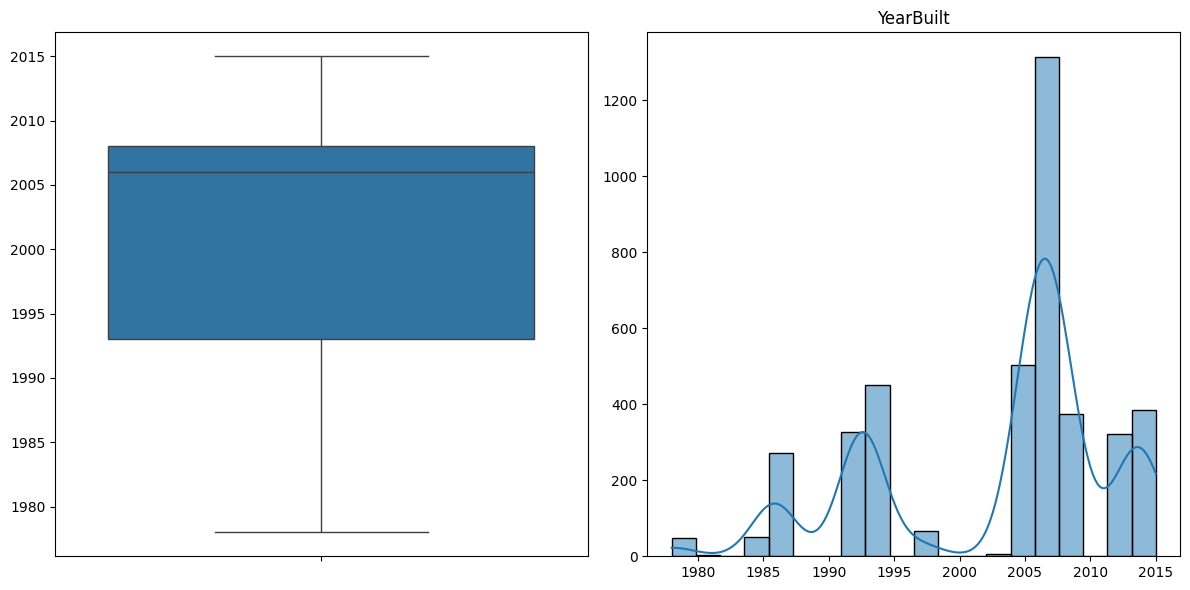

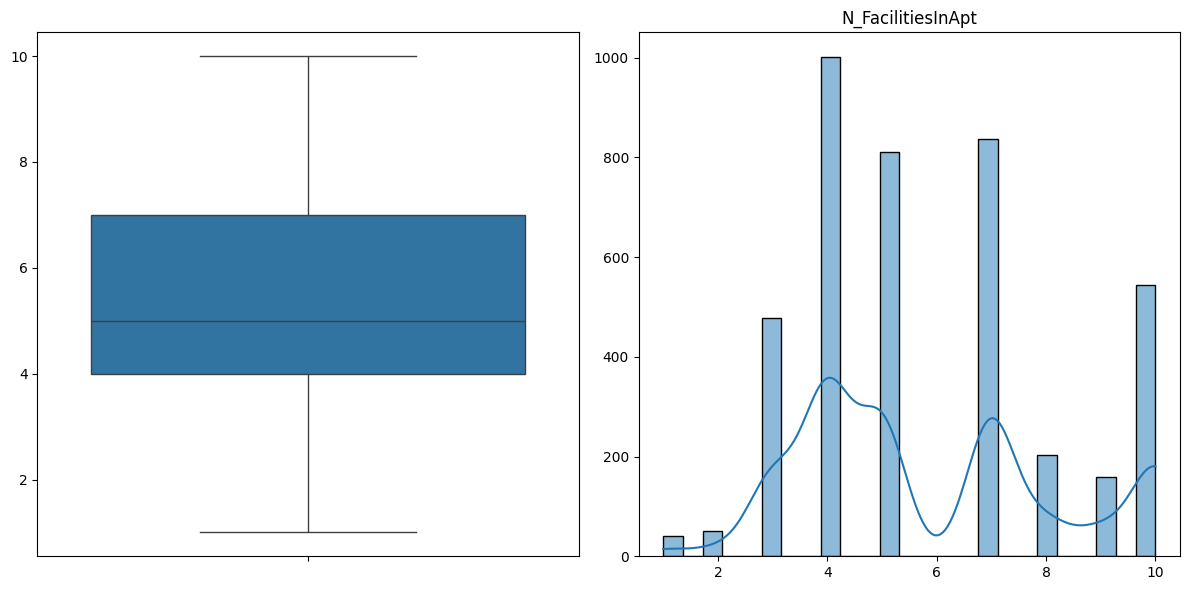

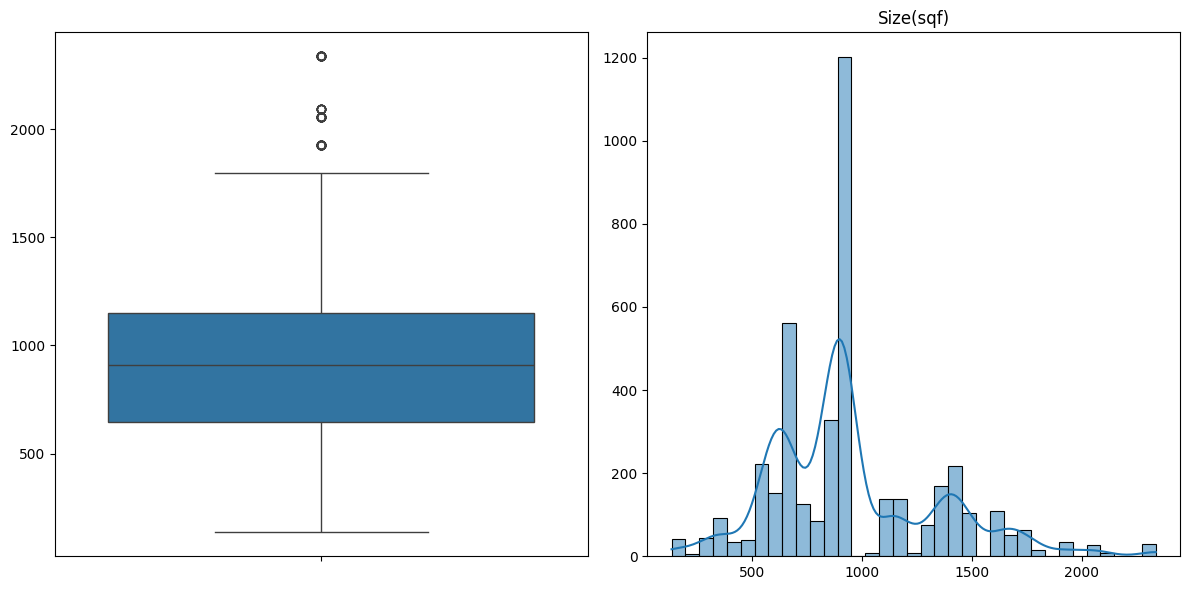

In [13]:
for i in X.drop(columns=['HallwayType', 'TimeToSubway', 'SubwayStation']).columns: 
    fig, (ax_box, ax_hist) = plt.subplots(1, 2, figsize=(12, 6))
    sns.boxplot(df[i], ax=ax_box)
    ax_box.set(title='', xlabel='', ylabel='')
    sns.histplot(df[i], ax=ax_hist, kde=True)
    ax_hist.set(title='', xlabel='', ylabel='')
    plt.title(i)
    plt.tight_layout()
    plt.show()

In [14]:
X.columns

Index(['HallwayType', 'TimeToSubway', 'SubwayStation',
       'N_FacilitiesNearBy(ETC)', 'N_FacilitiesNearBy(PublicOffice)',
       'N_SchoolNearBy(University)', 'N_Parkinglot(Basement)', 'YearBuilt',
       'N_FacilitiesInApt', 'Size(sqf)'],
      dtype='object')

- Ordinal Encoder : TimeToSubway (memiliki tingkatan)  
- One Hot Encoder : HallwayType, SubwayStation   
- MinMax Scaller : N_FacilitiesNearBy(ETC), N_FacilitiesNearBy(PublicOffice) , N_SchoolNearBy(University), N_Parkinglot(Basement),  YearBuilt, N_FacilitiesInApt (tidak memiliki outlier)
- Robust Scaler : Size(sqf) (memiliki outlier)

In [15]:
## untuk linear regression (one hot encoder drop first)
preprocessor = ColumnTransformer([
    ('OE', OrdinalEncoder(categories=categories), ['TimeToSubway']),
    ('OH', OneHotEncoder(drop='first'), ['HallwayType', 'SubwayStation']),
    ('MMS', MinMaxScaler(), ['N_FacilitiesNearBy(ETC)', 'N_FacilitiesNearBy(PublicOffice)', 'N_SchoolNearBy(University)', 'N_Parkinglot(Basement)', 'YearBuilt', 'N_FacilitiesInApt']),
    ('RS', RobustScaler(), ['Size(sqf)']),
])

In [16]:
X_train_preprocess = pd.DataFrame(preprocessor.fit_transform(X_train))
X_test_preprocess = pd.DataFrame(preprocessor.transform(X_test))

X_train_preprocess.columns = preprocessor.get_feature_names_out()
X_test_preprocess.columns = preprocessor.get_feature_names_out()

In [17]:
X_test_preprocess.head()

,OE__TimeToSubway,OH__HallwayType_mixed,OH__HallwayType_terraced,OH__SubwayStation_Banwoldang,OH__SubwayStation_Chil-sung-market,OH__SubwayStation_Daegu,OH__SubwayStation_Kyungbuk_uni_hospital,OH__SubwayStation_Myung-duk,OH__SubwayStation_Sin-nam,OH__SubwayStation_no_subway_nearby,MMS__N_FacilitiesNearBy(ETC),MMS__N_FacilitiesNearBy(PublicOffice),MMS__N_SchoolNearBy(University),MMS__N_Parkinglot(Basement),MMS__YearBuilt,MMS__N_FacilitiesInApt,RS__Size(sqf)
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.714286,0.6,0.704012,0.945946,0.666667,0.000000
1,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.2,0.714286,0.2,0.000000,0.216216,0.333333,0.007752
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.4,0.714286,0.0,0.057532,0.189189,0.222222,-0.453488
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.428571,0.4,0.961393,0.783784,1.000000,1.420543
4,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.2,0.714286,0.2,0.000000,0.216216,0.333333,0.428295


### Model Training

##### Linear Regression : (Base)

In [102]:
model_LR = LinearRegression()
model_LR.fit(X_train_preprocess, y_train)
y_pred_tr_L = model_LR.predict(X_train_preprocess)
y_pred_ts_L = model_LR.predict(X_test_preprocess)
print(f"""
    Linear Regression : 
    train r2 score : {r2_score(y_train, y_pred_tr_L)}
    train rmse : {root_mean_squared_error(y_train, y_pred_tr_L)}
    test r2 score : {r2_score(y_test, y_pred_ts_L)}    
    test rmse : {root_mean_squared_error(y_test, y_pred_ts_L)} 
""")


    Linear Regression : 
    train r2 score : 0.7656839282422455
    train rmse : 52001.806871299974
    test r2 score : 0.7583975907851248    
    test rmse : 51044.17744943799 



model sudah cukup baik dengan nilai yang stabil antara nilai train dan test pada r2_score maupun rmse

##### Linear Regression with Polynomial

```python
skf = KFold(n_splits=5, random_state=42, shuffle=True)
poly_pipe = Pipeline([
        ('poly', PolynomialFeatures(include_bias=False, interaction_only=False)),
        ('linear', LinearRegression()),
])

param_L = {
    'poly__degree' : range(1, 7)
}
scoring = { 'R2_Score': 'r2', 'RMSE': 'neg_mean_squared_error' }

GSCV_L = GridSearchCV(poly_pipe, param_L, cv=skf, scoring=scoring, refit='R2_Score', n_jobs=16, error_score='raise')
GSCV_L.fit(X_train_preprocess, y_train)
```

```python
GSCV_L.best_score_
```
np.float64(0.8316707008216031)

```python
pd.DataFrame(GSCV_L.cv_results_)[pd.DataFrame(GSCV_L.cv_results_)['rank_test_R2_Score'] == 1][['params', 'mean_test_R2_Score']]
```
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>params</th>
      <th>mean_test_R2_Score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1</th>
      <td>{'poly__degree': 2}</td>
      <td>0.831671</td>
    </tr>
  </tbody>
</table>
</div>

In [176]:
## L_best = GSCV_L.best_params_
poly = PolynomialFeatures(degree=2)
X_tr_Poly = poly.fit_transform(X_train_preprocess)
X_ts_Poly = poly.transform(X_test_preprocess)
model_LR_Best = LinearRegression()
model_LR_Best.fit(X_tr_Poly, y_train)
y_pred_tr_L_best = model_LR_Best.predict(X_tr_Poly)
y_pred_ts_L_best = model_LR_Best.predict(X_ts_Poly)
print(f"""
    Decision Tree : 
    train r2 score : {r2_score(y_train, y_pred_tr_L_best)}
    train rmse : {root_mean_squared_error(y_train, y_pred_tr_L_best)}
    test r2 score : {r2_score(y_test, y_pred_ts_L_best)}    
    test rmse : {root_mean_squared_error(y_test, y_pred_ts_L_best)}
""")


    Decision Tree : 
    train r2 score : 0.8373368700671137
    train rmse : 43327.33304020214
    test r2 score : 0.8337360127513966    
    test rmse : 42344.272427760094



nilai nya naik significant dari linear regression default (tanpa poly)

##### default lasso and ridge : 

In [26]:
model_L = Lasso()
model_R = Ridge()

model_L.fit(X_train_preprocess, y_train)
model_R.fit(X_train_preprocess, y_train)

y_pred_tr_lasso = model_L.predict(X_train_preprocess)
y_pred_ts_lasso = model_L.predict(X_test_preprocess)

y_pred_tr_ridge = model_R.predict(X_train_preprocess)
y_pred_ts_ridge = model_R.predict(X_test_preprocess)

print(f"""
    Lasso : 
    train r2 score : {r2_score(y_train, y_pred_tr_lasso)}
    train rmse : {root_mean_squared_error(y_train, y_pred_tr_lasso)}
    test r2 score : {r2_score(y_test, y_pred_ts_lasso)}    
    test rmse : {root_mean_squared_error(y_test, y_pred_ts_lasso)}

    Ridge : 
    train r2 score : {r2_score(y_train, y_pred_tr_ridge)}
    train rmse : {root_mean_squared_error(y_train, y_pred_tr_ridge)}
    test r2 score : {r2_score(y_test, y_pred_ts_ridge)}    
    test rmse : {root_mean_squared_error(y_test, y_pred_ts_ridge)}  
""")


    Lasso : 
    train r2 score : 0.7656836926021614
    train rmse : 52001.83301911599
    test r2 score : 0.7583765275364349    
    test rmse : 51046.40245368131

    Ridge : 
    train r2 score : 0.7656419824356315
    train rmse : 52006.461183119434
    test r2 score : 0.7582594367732962    
    test rmse : 51058.76950190718  



default lasso dan ridge keduanya tidak menghasilkan improvement yang significant, walaupun nilainya lebih baik.

##### Tuned Lasso and Ridge :

In [27]:
skf = KFold(n_splits=5, random_state=42, shuffle=True)
param_Lasso = { 
    'alpha': [0.001, 0.01, 1, 10, 20, 30, 40, 50, 100], 
    'max_iter': [1000, 2000, 3000],
    'random_state' : [42],
}
scoring = { 'R2_Score': 'r2', 'RMSE': 'neg_mean_squared_error' }

GSCV_Lasso = GridSearchCV(Lasso(), param_Lasso, cv=skf, scoring=scoring, refit='R2_Score', n_jobs=16)
GSCV_Lasso.fit(X_train_preprocess, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Lasso(), n_jobs=16,
             param_grid={'alpha': [0.001, 0.01, 1, 10, 20, 30, 40, 50, 100],
                         'max_iter': [1000, 2000, 3000], 'random_state': [42]},
             refit='R2_Score',
             scoring={'R2_Score': 'r2', 'RMSE': 'neg_mean_squared_error'})

In [28]:
GSCV_Lasso.best_score_

np.float64(0.7615739660388565)

In [29]:
pd.DataFrame(GSCV_Lasso.cv_results_)[pd.DataFrame(GSCV_Lasso.cv_results_)['rank_test_R2_Score'] == 1][['params', 'mean_test_R2_Score']]

,params,mean_test_R2_Score
21,"{'alpha': 50, 'max_iter': 1000, 'random_state'...",0.761574
22,"{'alpha': 50, 'max_iter': 2000, 'random_state'...",0.761574
23,"{'alpha': 50, 'max_iter': 3000, 'random_state'...",0.761574


In [177]:
lasso_best = GSCV_Lasso.best_params_
model_L_Best = Lasso(**lasso_best)
model_L_Best.fit(X_train_preprocess, y_train)
y_pred_tr_lasso_best = model_L_Best.predict(X_train_preprocess)
y_pred_ts_lasso_best = model_L_Best.predict(X_test_preprocess)
print(f"""
    Lasso : 
    train r2 score : {r2_score(y_train, y_pred_tr_lasso_best)}
    train rmse : {root_mean_squared_error(y_train, y_pred_tr_lasso_best)}
    test r2 score : {r2_score(y_test, y_pred_ts_lasso_best)}    
    test rmse : {root_mean_squared_error(y_test, y_pred_ts_lasso_best)}
""")


    Lasso : 
    train r2 score : 0.7655706558918585
    train rmse : 52014.37462890359
    test r2 score : 0.7579491249126229    
    test rmse : 51091.52995428659



In [31]:
skf = KFold(n_splits=5, random_state=42, shuffle=True)
param_Ridge = { 
    'alpha': [0.001, 0.01, 1, 10, 20, 30, 40, 50, 100], 
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'], 
    'random_state' : [42],
}
scoring = { 'R2_Score': 'r2', 'RMSE': 'neg_mean_squared_error' }

GSCV_Ridge = GridSearchCV(Ridge(), param_Ridge, cv=skf, scoring=scoring, refit='R2_Score', n_jobs=16)
GSCV_Ridge.fit(X_train_preprocess, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Ridge(), n_jobs=16,
             param_grid={'alpha': [0.001, 0.01, 1, 10, 20, 30, 40, 50, 100],
                         'random_state': [42],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga']},
             refit='R2_Score',
             scoring={'R2_Score': 'r2', 'RMSE': 'neg_mean_squared_error'})

In [32]:
GSCV_Ridge.best_score_

np.float64(0.7613480727199032)

In [33]:
pd.DataFrame(GSCV_Ridge.cv_results_)[pd.DataFrame(GSCV_Ridge.cv_results_)['rank_test_R2_Score'] == 1][['params', 'mean_test_R2_Score']]

,params,mean_test_R2_Score
15,"{'alpha': 1, 'random_state': 42, 'solver': 'svd'}",0.761348


In [34]:
ridge_best = GSCV_Ridge.best_params_
model_R_Best = Ridge(**ridge_best)
model_R_Best.fit(X_train_preprocess, y_train)
y_pred_tr_ridge_best = model_R_Best.predict(X_train_preprocess)
y_pred_ts_ridge_best = model_R_Best.predict(X_test_preprocess)
print(f"""
    Ridge : 
    train r2 score : {r2_score(y_train, y_pred_tr_ridge_best)}
    train rmse : {root_mean_squared_error(y_train, y_pred_tr_ridge_best)}
    test r2 score : {r2_score(y_test, y_pred_ts_ridge_best)}    
    test rmse : {root_mean_squared_error(y_test, y_pred_ts_ridge_best)}
""")


    Ridge : 
    train r2 score : 0.7656419824356314
    train rmse : 52006.46118311944
    test r2 score : 0.7582594367732967    
    test rmse : 51058.76950190713



semua linear model walaupun menggunakan tuning sekalipun menghasilkan score yang mirip.

##### Decision Tree Regressor

In [63]:
model_DT = DecisionTreeRegressor()
model_DT.fit(X_train_preprocess, y_train)

y_pred_tr_DT = model_DT.predict(X_train_preprocess)
y_pred_ts_DT = model_DT.predict(X_test_preprocess)

print(f"""
    Decision Tree : 
    train r2 score : {r2_score(y_train, y_pred_tr_DT)}
    train rmse : {root_mean_squared_error(y_train, y_pred_tr_DT)}
    test r2 score : {r2_score(y_test, y_pred_ts_DT)}    
    test rmse : {root_mean_squared_error(y_test, y_pred_ts_DT)}
""")


    Decision Tree : 
    train r2 score : 0.8467618458055277
    train rmse : 42053.374538332406
    test r2 score : 0.8430174051876173    
    test rmse : 41145.40401764454



hasilnya lebih baik significant dari linear model bak pada r2 score maupun rmse

##### Tuned Decision Tree Regressor: 

In [64]:
skf = KFold(n_splits=5, random_state=42, shuffle=True)
param_DTR = {
    'max_depth': list(range(2, 150)) + [None],
    'min_samples_split': range(2, 21),
    'min_samples_leaf': range(1,21),
    'random_state' : [42],
}

scoring = { 'R2_Score': 'r2', 'RMSE': 'neg_mean_squared_error' }

# Perform grid search
GSCV_DTR = GridSearchCV(DecisionTreeRegressor(), param_DTR, cv=skf, scoring=scoring, refit='R2_Score', n_jobs=16)
GSCV_DTR.fit(X_train_preprocess, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=16,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                       24, 25, 26, 27, 28, 29, 30, 31, ...],
                         'min_samples_leaf': range(1, 21),
                         'min_samples_split': range(2, 21),
                         'random_state': [42]},
             refit='R2_Score',
             scoring={'R2_Score': 'r2', 'RMSE': 'neg_mean_squared_error'})

In [65]:
GSCV_DTR.best_score_

np.float64(0.8307920647392141)

In [66]:
pd.DataFrame(GSCV_DTR.cv_results_)[pd.DataFrame(GSCV_DTR.cv_results_)['rank_test_R2_Score'] == 1][['params', 'mean_test_R2_Score']]

,params,mean_test_R2_Score
3433,"{'max_depth': 11, 'min_samples_leaf': 1, 'min_...",0.830792


In [67]:
DT_best = GSCV_DTR.best_params_
model_DT_Best = DecisionTreeRegressor(**DT_best)
model_DT_Best.fit(X_train_preprocess, y_train)
y_pred_tr_DT_best = model_DT_Best.predict(X_train_preprocess)
y_pred_ts_DT_best = model_DT_Best.predict(X_test_preprocess)
print(f"""
    Decision Tree : 
    train r2 score : {r2_score(y_train, y_pred_tr_DT_best)}
    train rmse : {root_mean_squared_error(y_train, y_pred_tr_DT_best)}
    test r2 score : {r2_score(y_test, y_pred_ts_DT_best)}    
    test rmse : {root_mean_squared_error(y_test, y_pred_ts_DT_best)}
""")


    Decision Tree : 
    train r2 score : 0.8463704484153916
    train rmse : 42107.04617238733
    test r2 score : 0.8427793414041593    
    test rmse : 41176.590658958055



Decision Tre yang telah di Tune menghasilkan score yang sedikit lebih buruh dari default?

##### KNeighbor Regressor

In [68]:
model_KN = KNeighborsRegressor()
model_KN.fit(X_train_preprocess, y_train)

y_pred_tr_KN = model_KN.predict(X_train_preprocess)
y_pred_ts_KN = model_KN.predict(X_test_preprocess)

print(f"""
    KNeighbor Regressor : 
    train r2 score : {r2_score(y_train, y_pred_tr_KN)}
    train rmse : {root_mean_squared_error(y_train, y_pred_tr_KN)}
    test r2 score : {r2_score(y_test, y_pred_ts_KN)}    
    test rmse : {root_mean_squared_error(y_test, y_pred_ts_KN)}
""")


    KNeighbor Regressor : 
    train r2 score : 0.821654940890896
    train rmse : 45367.822605055895
    test r2 score : 0.820313939619583    
    test rmse : 44020.27718544868



KNeighbor Regressor menghasilkan score yang significan lebih baik dari linear model, tetapi berada dibawah score yang dihasilkan oleh Decision Tree default parameter.

##### Tuned KNeighbor Regressor

In [69]:
skf = KFold(n_splits=5, random_state=42, shuffle=True)
param_KNR = {
    'n_neighbors': range(1, 150, 2), 
    'weights': ['uniform', 'distance'], 
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'p': [1, 2]
}
scoring = { 'R2_Score': 'r2', 'RMSE': 'neg_mean_squared_error' }

# Perform grid search
GSCV_KN = GridSearchCV(KNeighborsRegressor(), param_KNR, cv=skf, scoring=scoring, refit='R2_Score', n_jobs=16)
GSCV_KN.fit(X_train_preprocess, y_train)

c:\Users\Kenneth Aleanda\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=16,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': range(1, 150, 2), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             refit='R2_Score',
             scoring={'R2_Score': 'r2', 'RMSE': 'neg_mean_squared_error'})

In [70]:
GSCV_KN.best_score_

np.float64(0.8308456164623197)

In [71]:
GSCV_KN.best_score_

np.float64(0.8308456164623197)

In [72]:
pd.DataFrame(GSCV_KN.cv_results_)[pd.DataFrame(GSCV_KN.cv_results_)['rank_test_R2_Score'] == 1][['params', 'mean_test_R2_Score']]

,params,mean_test_R2_Score
899,"{'algorithm': 'kd_tree', 'n_neighbors': 149, '...",0.830846


In [73]:
KN_best = GSCV_KN.best_params_
model_KN_Best = KNeighborsRegressor(**KN_best)
model_KN_Best.fit(X_train_preprocess, y_train)
y_pred_tr_KN_best = model_KN_Best.predict(X_train_preprocess)
y_pred_ts_KN_best = model_KN_Best.predict(X_test_preprocess)
print(f"""
    KNeighbor Regressor : 
    train r2 score : {r2_score(y_train, y_pred_tr_KN_best)}
    train rmse : {root_mean_squared_error(y_train, y_pred_tr_KN_best)}
    test r2 score : {r2_score(y_test, y_pred_ts_KN_best)}    
    test rmse : {root_mean_squared_error(y_test, y_pred_ts_KN_best)}
""")


    KNeighbor Regressor : 
    train r2 score : 0.8467507146325597
    train rmse : 42054.90188277193
    test r2 score : 0.8431677439045207    
    test rmse : 41125.69728215781



In [74]:
pd.DataFrame(GSCV_KN.cv_results_)[pd.DataFrame(GSCV_KN.cv_results_)['rank_test_R2_Score'] == 1][['params', 'mean_test_R2_Score']]

,params,mean_test_R2_Score
899,"{'algorithm': 'kd_tree', 'n_neighbors': 149, '...",0.830846


In [75]:
KN_best = GSCV_KN.best_params_
model_KN_Best = KNeighborsRegressor(**KN_best)
model_KN_Best.fit(X_train_preprocess, y_train)
y_pred_tr_KN_best = model_KN_Best.predict(X_train_preprocess)
y_pred_ts_KN_best = model_KN_Best.predict(X_test_preprocess)
print(f"""
    KNeighbor Regressor : 
    train r2 score : {r2_score(y_train, y_pred_tr_KN_best)}
    train rmse : {root_mean_squared_error(y_train, y_pred_tr_KN_best)}
    test r2 score : {r2_score(y_test, y_pred_ts_KN_best)}    
    test rmse : {root_mean_squared_error(y_test, y_pred_ts_KN_best)}
""")


    KNeighbor Regressor : 
    train r2 score : 0.8467507146325597
    train rmse : 42054.90188277193
    test r2 score : 0.8431677439045207    
    test rmse : 41125.69728215781



tuned KNeighbor Regressor memiliki nili sangat mirip dengan Decision Tree dengan parameter Default (yang terbaik sejauh ini)

##### One Hot Encoder Tanpa Drop First

In [76]:
## untuk linear regression (one hot encoder drop first)
preprocessor_nd = ColumnTransformer([
    ('OE', OrdinalEncoder(categories=categories), ['TimeToSubway']),
    ('OH', OneHotEncoder(), ['HallwayType', 'SubwayStation']),
    ('MMS', MinMaxScaler(), ['N_FacilitiesNearBy(ETC)', 'N_FacilitiesNearBy(PublicOffice)', 'N_SchoolNearBy(University)', 'N_Parkinglot(Basement)', 'YearBuilt', 'N_FacilitiesInApt']),
    ('RS', RobustScaler(), ['Size(sqf)']),
])

In [77]:
X_train_preprocess_nd = pd.DataFrame(preprocessor_nd.fit_transform(X_train))
X_test_preprocess_nd = pd.DataFrame(preprocessor_nd.transform(X_test))

X_train_preprocess_nd.columns = preprocessor_nd.get_feature_names_out()
X_test_preprocess_nd.columns = preprocessor_nd.get_feature_names_out()

##### Decision Tree Regressor

In [78]:
pipeline = Pipeline([
    ('preprocessor', preprocessor_nd),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict using the pipeline
y_pred_tr_DT_nd = pipeline.predict(X_train)
y_pred_ts_DT_nd = pipeline.predict(X_test)

# Calculate and print the scores
print(f"""
    Decision Tree : 
    train r2 score : {r2_score(y_train, y_pred_tr_DT_nd)}
    train rmse : {root_mean_squared_error(y_train, y_pred_tr_DT_nd)}
    test r2 score : {r2_score(y_test, y_pred_ts_DT_nd)}    
    test rmse : {root_mean_squared_error(y_test, y_pred_ts_DT_nd)}
""")


    Decision Tree : 
    train r2 score : 0.8467618458055277
    train rmse : 42053.374538332406
    test r2 score : 0.8430174051876173    
    test rmse : 41145.40401764454



In [110]:
model_DT_nd = DecisionTreeRegressor(random_state=42)
model_DT_nd.fit(X_train_preprocess_nd, y_train)

DecisionTreeRegressor(random_state=42)

Decision Tree Regressor dengan OneHot Encoder tanpa drop first memiliki nilai yang sama persis dengan Default Decision Tree (dengan drop first)

##### KNeighbor Regressor

In [79]:
pipeline = Pipeline([
    ('preprocessor', preprocessor_nd),
    ('regressor', KNeighborsRegressor())
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict using the pipeline
y_pred_tr_KN_nd = pipeline.predict(X_train)
y_pred_ts_KN_nd = pipeline.predict(X_test)

# Calculate and print the scores
print(f"""
    KNeighbor Regression: 
    train r2 score : {r2_score(y_train, y_pred_tr_KN_nd)}
    train rmse : {root_mean_squared_error(y_train, y_pred_tr_KN_nd)}
    test r2 score : {r2_score(y_test, y_pred_ts_KN_nd)}    
    test rmse : {root_mean_squared_error(y_test, y_pred_ts_KN_nd)}
""")


    KNeighbor Regression: 
    train r2 score : 0.8214622577299611
    train rmse : 45392.323579970755
    test r2 score : 0.8193647698976784    
    test rmse : 44136.38992507299



In [180]:
model_KN_nd = KNeighborsRegressor()
model_KN_nd.fit(X_train_preprocess_nd, y_train)

KNeighborsRegressor()

KNeigbor Regressor dengan One Hot Encoder tanpa drop first memiliki nilai yang hampir sama dengan Default KNeighbor Decision Tree (dengan drop first)

##### Ensemble - Random Forest Regressor

In [80]:
model_RFR = RandomForestRegressor()
model_RFR.fit(X_train_preprocess, y_train)

y_pred_tr_RFR = model_RFR.predict(X_train_preprocess)
y_pred_ts_RFR = model_RFR.predict(X_test_preprocess)

print(f"""
    KNeighbor Regression: 
    train r2 score : {r2_score(y_train, y_pred_tr_RFR)}
    train rmse : {root_mean_squared_error(y_train, y_pred_tr_RFR)}
    test r2 score : {r2_score(y_test, y_pred_ts_RFR)}    
    test rmse : {root_mean_squared_error(y_test, y_pred_ts_RFR)}
""")



    KNeighbor Regression: 
    train r2 score : 0.8465154816490406
    train rmse : 42087.16600289577
    test r2 score : 0.8429846358420277    
    test rmse : 41149.69824405056



##### Tuned Ensemble - Random Forest Regressor

```python
skf = KFold(n_splits=5, random_state=42, shuffle=True)
param_RFR = {
'n_estimators': range(1, 200, 2), 
'max_depth': list(range(1, 51, 2)) + [None], 
'min_samples_split': range(2, 21), 
'min_samples_leaf': range(1, 21), 
'max_features': ['auto', 'sqrt', 'log2']
}
scoring = { 'R2_Score': 'r2', 'RMSE': 'neg_mean_squared_error' }

# Perform grid search
GSCV_RFR = GridSearchCV(RandomForestRegressor(), param_RFR, cv=skf, scoring=scoring, refit='R2_Score', n_jobs=16)
GSCV_RFR.fit(X_train_preprocess, y_train)
```

In [130]:
skf = KFold(n_splits=5, random_state=42, shuffle=True)
param_RFR = {
'n_estimators': range(2, 201, 2), 
'max_depth': list(range(1, 51, 2)) + [None], 
'min_samples_split': range(2, 21), 
'min_samples_leaf': range(1, 21), 
'max_features': ['sqrt', 'log2'],
'random_state' : [42]
}
scoring = { 'R2_Score': 'r2', 'RMSE': 'neg_mean_squared_error' }

# Perform grid search
RSCV_RFR = RandomizedSearchCV(RandomForestRegressor(), param_RFR, cv=skf, n_iter=10000,scoring=scoring, refit='R2_Score', n_jobs=20, error_score='raise')
RSCV_RFR.fit(X_train_preprocess, y_train)

c:\Users\Kenneth Aleanda\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   error_score='raise', estimator=RandomForestRegressor(),
                   n_iter=10000, n_jobs=20,
                   param_distributions={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15,
                                                      17, 19, 21, 23, 25, 27,
                                                      29, 31, 33, 35, 37, 39,
                                                      41, 43, 45, 47, 49,
                                                      None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': range(1, 21),
                                        'min_samples_split': range(2, 21),
                                        'n_estimators': range(2, 201, 2),
                                        'random_state': [42]},
                   refit='R2_Score',
                   scoring={'R2_Score': 'r2', 'RMSE': 'neg_mean_squared_error'})

In [131]:
RSCV_RFR.best_score_

np.float64(0.8353755496147098)

In [132]:
pd.DataFrame(RSCV_RFR.cv_results_)[pd.DataFrame(RSCV_RFR.cv_results_)['rank_test_R2_Score'] == 1][['params', 'mean_test_R2_Score']]

,params,mean_test_R2_Score
9918,"{'random_state': 42, 'n_estimators': 16, 'min_...",0.835376


In [133]:
RSCV_RFR.best_params_


{'random_state': 42,
 'n_estimators': 16,
 'min_samples_split': 17,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 9}

In [134]:
RFR_best = RSCV_RFR.best_params_
model_RFR_Best = RandomForestRegressor(**RFR_best)
model_RFR_Best.fit(X_train_preprocess, y_train)
y_pred_tr_RFR_best = model_RFR_Best.predict(X_train_preprocess)
y_pred_ts_RFR_best = model_RFR_Best.predict(X_test_preprocess)
print(f"""
    Random Forest Regressor Regressor : 
    train r2 score : {r2_score(y_train, y_pred_tr_RFR_best)}
    train rmse : {root_mean_squared_error(y_train, y_pred_tr_RFR_best)}
    test r2 score : {r2_score(y_test, y_pred_ts_RFR_best)}    
    test rmse : {root_mean_squared_error(y_test, y_pred_ts_RFR_best)}
""")


    Random Forest Regressor Regressor : 
    train r2 score : 0.8449715154677366
    train rmse : 42298.322672602524
    test r2 score : 0.8423423062589742    
    test rmse : 41233.7813899043



##### Ensemble - Gradient Boosting Regressor

In [135]:
model_GBR = GradientBoostingRegressor(random_state=42)
model_GBR.fit(X_train_preprocess, y_train)
y_pred_tr_GBR = model_GBR.predict(X_train_preprocess)
y_pred_ts_GBR = model_GBR.predict(X_test_preprocess)
print(f"""
    Random Forest Regressor Regressor : 
    train r2 score : {r2_score(y_train, y_pred_tr_GBR)}
    train rmse : {root_mean_squared_error(y_train, y_pred_tr_GBR)}
    test r2 score : {r2_score(y_test, y_pred_ts_GBR)}    
    test rmse : {root_mean_squared_error(y_test, y_pred_ts_GBR)}
""")


    Random Forest Regressor Regressor : 
    train r2 score : 0.8442629443857509
    train rmse : 42394.876540465884
    test r2 score : 0.841927904908695    
    test rmse : 41287.93707539372



##### Tuned Ensemble - Gradient Boosting Regressor 

In [136]:
skf = KFold(n_splits=5, random_state=42, shuffle=True)
param_RFR = {
    'n_estimators': randint(50, 300), 
    'learning_rate': uniform(0.01, 0.2), 
    'max_depth': randint(3, 10), 
    'min_samples_split': randint(2, 21), 
    'min_samples_leaf': randint(1, 21), 
    'subsample': uniform(0.8, 0.2), 
    'max_features': ['log2', 'sqrt',]
}
scoring = { 'R2_Score': 'r2', 'RMSE': 'neg_mean_squared_error' }

# Perform grid search
RSCV_GBR = RandomizedSearchCV(GradientBoostingRegressor(random_state=42), param_RFR, cv=skf, n_iter=10000,scoring=scoring, refit='R2_Score', n_jobs=16, error_score='raise')
RSCV_GBR.fit(X_train_preprocess, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   error_score='raise',
                   estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=10000, n_jobs=16,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001E4A55F3370>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen...
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E4A55F2E60>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E4C2BE70A0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001E4A55F1C90>},
                   refit='R2_Score',
                   scoring={'R2_Score': 'r2', 'RMSE': 'neg_mean_squared_error'})

In [137]:
RSCV_GBR.best_score_

np.float64(0.8365175918947712)

In [138]:
pd.DataFrame(RSCV_GBR.cv_results_)[pd.DataFrame(RSCV_GBR.cv_results_)['rank_test_R2_Score'] == 1][['params', 'mean_test_R2_Score']]

,params,mean_test_R2_Score
1287,"{'learning_rate': 0.11193500877280173, 'max_de...",0.836518


In [139]:
RSCV_GBR.best_params_


{'learning_rate': np.float64(0.11193500877280173),
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 13,
 'n_estimators': 266,
 'subsample': np.float64(0.9992937536190075)}

In [140]:
GBR_best = RSCV_GBR.best_params_
model_GBR_Best = GradientBoostingRegressor(**GBR_best)
model_GBR_Best.fit(X_train_preprocess, y_train)
y_pred_tr_GBR_best = model_GBR_Best.predict(X_train_preprocess)
y_pred_ts_GBR_best = model_GBR_Best.predict(X_test_preprocess)
print(f"""
    Random Forest Regressor Regressor : 
    train r2 score : {r2_score(y_train, y_pred_tr_GBR_best)}
    train rmse : {root_mean_squared_error(y_train, y_pred_tr_GBR_best)}
    test r2 score : {r2_score(y_test, y_pred_ts_GBR_best)}    
    test rmse : {root_mean_squared_error(y_test, y_pred_ts_GBR_best)}
""")


    Random Forest Regressor Regressor : 
    train r2 score : 0.8455746374665217
    train rmse : 42215.963906769655
    test r2 score : 0.8433941365149028    
    test rmse : 41096.003402069684



##### Ensemble - Stacking Regressor

In [156]:
base_models = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor())
]
meta_model = RandomForestRegressor(random_state=42)

model_SR = StackingRegressor(estimators=base_models, final_estimator=meta_model)
model_SR.fit(X_train_preprocess, y_train)
y_pred_tr_SR = model_SR.predict(X_train_preprocess)
y_pred_ts_SR = model_SR.predict(X_test_preprocess)
print(f"""
    Random Forest Regressor Regressor : 
    train r2 score : {r2_score(y_train, y_pred_tr_SR)}
    train rmse : {root_mean_squared_error(y_train, y_pred_tr_SR)}
    test r2 score : {r2_score(y_test, y_pred_ts_SR)}    
    test rmse : {root_mean_squared_error(y_test, y_pred_ts_SR)}
""")


    Random Forest Regressor Regressor : 
    train r2 score : 0.8405638272003242
    train rmse : 42895.410219958205
    test r2 score : 0.8356456490254347    
    test rmse : 42100.39613811659



##### Tuned Ensemble - Stacking Regressor

In [158]:
poly_linear_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ('linear_regression', LinearRegression())
])

decision_tree = DecisionTreeRegressor(**model_DT.get_params())
random_forest = RandomForestRegressor(**model_RFR.get_params())

model_SR = StackingRegressor(
    estimators=[
        ('poly_linear', poly_linear_pipeline),
        ('decision_tree', decision_tree),
        ('random_forest', random_forest)
    ],
    final_estimator=RandomForestRegressor(n_estimators=100, random_state=42)
)

model_SR_best = StackingRegressor(estimators=base_models, final_estimator=meta_model)
model_SR_best.fit(X_train_preprocess, y_train)
y_pred_tr_SR_best = model_SR_best.predict(X_train_preprocess)
y_pred_ts_SR_best = model_SR_best.predict(X_test_preprocess)
print(f"""
    Random Forest Regressor Regressor : 
    train r2 score : {r2_score(y_train, y_pred_tr_SR_best)}
    train rmse : {root_mean_squared_error(y_train, y_pred_tr_SR_best)}
    test r2 score : {r2_score(y_test, y_pred_ts_SR_best)}    
    test rmse : {root_mean_squared_error(y_test, y_pred_ts_SR_best)}
""")


    Random Forest Regressor Regressor : 
    train r2 score : 0.8405638272003242
    train rmse : 42895.410219958205
    test r2 score : 0.8356456490254347    
    test rmse : 42100.39613811659



#### Score Table

In [167]:
data = {
    'r2_score Train' : [r2_score(y_train, y_pred_tr_L), r2_score(y_train, y_pred_tr_L_best), r2_score(y_train, y_pred_tr_lasso), r2_score(y_train, y_pred_tr_lasso_best), r2_score(y_train, y_pred_tr_ridge), r2_score(y_train, y_pred_tr_ridge_best), r2_score(y_train, y_pred_tr_DT), r2_score(y_train, y_pred_tr_DT_best), r2_score(y_train, y_pred_tr_DT_nd), r2_score(y_train, y_pred_tr_KN), r2_score(y_train, y_pred_tr_KN_best), r2_score(y_train, y_pred_tr_KN_nd), r2_score(y_train, y_pred_tr_RFR), r2_score(y_train, y_pred_tr_RFR_best), r2_score(y_train, y_pred_tr_GBR), r2_score(y_train, y_pred_tr_GBR_best),r2_score(y_train, y_pred_tr_SR), r2_score(y_train, y_pred_tr_SR_best)],
    'r2_score Test' : [r2_score(y_test, y_pred_ts_L), r2_score(y_test, y_pred_ts_L_best), r2_score(y_test, y_pred_ts_lasso), r2_score(y_test, y_pred_ts_lasso_best), r2_score(y_test, y_pred_ts_ridge), r2_score(y_test, y_pred_ts_ridge_best), r2_score(y_test, y_pred_ts_DT), r2_score(y_test, y_pred_ts_DT_best), r2_score(y_test, y_pred_ts_DT_nd), r2_score(y_test, y_pred_ts_KN), r2_score(y_test, y_pred_ts_KN_best), r2_score(y_test, y_pred_ts_KN_nd), r2_score(y_test, y_pred_ts_RFR), r2_score(y_test, y_pred_ts_RFR_best), r2_score(y_test, y_pred_ts_GBR), r2_score(y_test, y_pred_ts_GBR_best), r2_score(y_test, y_pred_ts_SR), r2_score(y_test, y_pred_ts_SR_best)],    
    'rmse Train' : [root_mean_squared_error(y_train, y_pred_tr_L), root_mean_squared_error(y_train, y_pred_tr_L_best), root_mean_squared_error(y_train, y_pred_tr_lasso), root_mean_squared_error(y_train, y_pred_tr_lasso_best), root_mean_squared_error(y_train, y_pred_tr_ridge), root_mean_squared_error(y_train, y_pred_tr_ridge_best), root_mean_squared_error(y_train, y_pred_tr_DT), root_mean_squared_error(y_train, y_pred_tr_DT_best), root_mean_squared_error(y_train, y_pred_tr_DT_nd), root_mean_squared_error(y_train, y_pred_tr_KN), root_mean_squared_error(y_train, y_pred_tr_KN_best), root_mean_squared_error(y_train, y_pred_tr_KN_nd), root_mean_squared_error(y_train, y_pred_tr_RFR), root_mean_squared_error(y_train, y_pred_tr_RFR_best), root_mean_squared_error(y_train, y_pred_tr_GBR), root_mean_squared_error(y_train, y_pred_tr_GBR_best), root_mean_squared_error(y_train, y_pred_tr_SR), root_mean_squared_error(y_train, y_pred_tr_SR_best)],
    'rmse Test' : [root_mean_squared_error(y_test, y_pred_ts_L), root_mean_squared_error(y_test, y_pred_ts_L_best), root_mean_squared_error(y_test, y_pred_ts_lasso), root_mean_squared_error(y_test, y_pred_ts_lasso_best), root_mean_squared_error(y_test, y_pred_ts_ridge), root_mean_squared_error(y_test, y_pred_ts_ridge_best), root_mean_squared_error(y_test, y_pred_ts_DT), root_mean_squared_error(y_test, y_pred_ts_DT_best), root_mean_squared_error(y_test, y_pred_ts_DT_nd), root_mean_squared_error(y_test, y_pred_ts_KN), root_mean_squared_error(y_test, y_pred_ts_KN_best), root_mean_squared_error(y_test, y_pred_ts_KN_nd), root_mean_squared_error(y_test, y_pred_ts_RFR), root_mean_squared_error(y_test, y_pred_ts_RFR_best), root_mean_squared_error(y_test, y_pred_ts_GBR), root_mean_squared_error(y_test, y_pred_ts_GBR_best), root_mean_squared_error(y_test, y_pred_ts_SR), root_mean_squared_error(y_test, y_pred_ts_SR_best)],   
}

score_table = pd.DataFrame(data, index=['Linear Regression', 'Linear Regression (Poly)', 'Lasso', 'Lasso (Tuned)', 'Ridge', 'Ridge (Tuned)', 'Decision Tree', 'Decision Tree (Tuned)', 'Decision Tree (No Drop)', 'KNeighbor Regression', 'KNeighbor Regression (Tuned)', 'KNeigbor Regression (No Drop)', 'Random Forest Regressor', 'Random Forest Regressor (Tuned)', 'Gradient Boosting Regressor', 'Gradient Boosting Regressor (Tuned)', 'Stacking Regressor', 'Stacking Regressor (Tuned)'],)
score_table['r2_diff'] = abs(score_table['r2_score Train'] - score_table['r2_score Test'])
score_table['rmse_diff'] = abs(score_table['rmse Train'] - score_table['rmse Test'])
score_table = score_table[['r2_score Train', 'r2_score Test', 'r2_diff', 'rmse Train', 'rmse Test', 'rmse_diff']]
score_table.sort_values(['r2_score Train', 'r2_score Test'], ascending=False)

,r2_score Train,r2_score Test,r2_diff,rmse Train,rmse Test,rmse_diff
Decision Tree,0.846762,0.843017,0.003744,42053.374538,41145.404018,907.970521
Decision Tree (No Drop),0.846762,0.843017,0.003744,42053.374538,41145.404018,907.970521
KNeighbor Regression (Tuned),0.846751,0.843168,0.003583,42054.901883,41125.697282,929.204601
Random Forest Regressor,0.846515,0.842985,0.003531,42087.166003,41149.698244,937.467759
Decision Tree (Tuned),0.846370,0.842779,0.003591,42107.046172,41176.590659,930.455513
Gradient Boosting Regressor (Tuned),0.845575,0.843394,0.002181,42215.963907,41096.003402,1119.960505
Random Forest Regressor (Tuned),0.844972,0.842342,0.002629,42298.322673,41233.781390,1064.541283
Gradient Boosting Regressor,0.844263,0.841928,0.002335,42394.876540,41287.937075,1106.939465
Stacking Regressor,0.840564,0.835646,0.004918,42895.410220,42100.396138,795.014082
Stacking Regressor (Tuned),0.840564,0.835646,0.004918,42895.410220,42100.396138,795.014082


### Best Model Workflow

In [ ]:
# load data
df = pd.read_csv("./data/data_daegu_apartment.csv")

# independent and target variable 
X = df.drop(columns='SalePrice')
y = df['SalePrice']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)

# PreProcessor
preprocessor = ColumnTransformer([
    ('OE', OrdinalEncoder(categories=categories), ['TimeToSubway']),
    ('OH', OneHotEncoder(drop='first'), ['HallwayType', 'SubwayStation']),
    ('MMS', MinMaxScaler(), ['N_FacilitiesNearBy(ETC)', 'N_FacilitiesNearBy(PublicOffice)', 
                             'N_SchoolNearBy(University)', 'N_Parkinglot(Basement)', 'YearBuilt', 'N_FacilitiesInApt']),
    ('RS', RobustScaler(), ['Size(sqf)']),
])

best_model = Pipeline([
    ('preprocessor', preprocessor),
    ('Regressor', DecisionTreeRegressor(random_state=42)),
])
best_model.fit(X_train, y_train)

y_pred_tr_best = best_model.predict(X_train)
y_pred_ts_best = best_model.predict(X_test)
print(f"""
    Best Model (Decision Tree with default parameter) : 
    train r2 score : {r2_score(y_train, y_pred_tr_best)}
    train rmse : {root_mean_squared_error(y_train, y_pred_tr_best)}
    test r2 score : {r2_score(y_test, y_pred_ts_best)}    
    test rmse : {root_mean_squared_error(y_test, y_pred_ts_best)}
""")


    Best Model (Decision Tree with default parameter) : 
    train r2 score : 0.8467618458055277
    train rmse : 42053.374538332406
    test r2 score : 0.8430174051876173    
    test rmse : 41145.40401764454



#### Feature Importance 

In [142]:
pd.DataFrame({
    'Feature' : X_test_preprocess.columns,
    'Importance %' : ((model_DT.feature_importances_) * 100).round(4),
    'Coefficient' : model_L_Best.coef_,
}).sort_values(by='Importance %', ascending=False)

,Feature,Importance %,Coefficient
2,OH__HallwayType_terraced,48.5039,9573.727911
16,RS__Size(sqf),36.5828,79894.481307
15,MMS__N_FacilitiesInApt,6.5323,141061.463281
13,MMS__N_Parkinglot(Basement),4.6089,7328.631630
14,MMS__YearBuilt,1.3027,57805.513628
11,MMS__N_FacilitiesNearBy(PublicOffice),0.8755,-2261.114705
1,OH__HallwayType_mixed,0.7304,-13257.247413
12,MMS__N_SchoolNearBy(University),0.4046,-37877.634003
3,OH__SubwayStation_Banwoldang,0.1706,38813.889302
5,OH__SubwayStation_Daegu,0.1209,4898.410726


## Picke to Save Model

In [181]:
models = {
    'Linear Regression' : model_LR, 
    'Linear Regression (Poly)' : model_LR_Best, 
    'Lasso' : model_L, 
    'Lasso (Tuned)' : model_L_Best, 
    'Ridge' : model_R, 
    'Ridge (Tuned)' : model_R_Best, 
    'Decision Tree' : model_DT, 
    'Decision Tree (Tuned)' : model_DT_Best, 
    'Decision Tree (No Drop)' : model_DT_nd, 
    'KNeighbor Regression' : model_KN, 
    'KNeighbor Regression (Tuned)' : model_KN_Best, 
    'KNeigbor Regression (No Drop)' : model_KN_nd, 
    'Random Forest Regressor' : model_RFR, 
    'Random Forest Regressor (Tuned)' : model_RFR_Best, 
    'Gradient Boosting Regressor' : model_GBR, 
    'Gradient Boosting Regressor (Tuned)' : model_GBR_Best, 
    'Stacking Regressor' : model_SR, 
    'Stacking Regressor (Tuned)' : model_SR_best,
}

with open('models.pkl', 'wb') as file:
    pickle.dump(models, file)
